<a href="https://colab.research.google.com/github/margot-bonilla/violent-behaviour-recognition/blob/master/notebooks/iteration_with_keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violence Detection

# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Crate necessary folders for the execution
info_path = '/content/Info'
if not os.path.exists(info_path):
    os.makedirs(info_path)

logs_path = '/content/logs'
if not os.path.exists(logs_path):
    os.makedirs(logs_path)

models_path = '/content/models/checkpoints'
if not os.path.exists(models_path):
    os.makedirs(models_path)

## Constant information to set the data and engineering resources

In [ ]:
# Path information to load videos and annotations
import os

ROOT_PATH = r"/content/drive/MyDrive/UOC/TFM_2"
ANNOTATIONS_PATH = os.path.join(ROOT_PATH, "Annotations")
VIDEOS_PATH = os.path.join(ROOT_PATH, "Videos")
INFO_PATH = "Info"
MODELS_PATH = 'models'

LOGS_PATH = "logs"

DATASET_TRAIN_PATH = os.path.join(INFO_PATH, "violence_detection_train.hdf5")
DATASET_VAL_PATH = os.path.join(INFO_PATH, "violence_detection_val.hdf5")
DATASET_TEST_PATH = os.path.join(INFO_PATH, "violence_detection_test.hdf5")

## Krakov
KRAKOV_VIDEOS_PATH = os.path.join(ROOT_PATH, "Videos")
INCLUDE_KRAKOV = True

## Hockey
HOCKEY_VIDEOS_PATH = os.path.join(ROOT_PATH, "Hockey", "data")
INCLUDE_HOCKEY = True

## Movies
MOVIES_VIDEOS_PATH = os.path.join(ROOT_PATH, "movies")
INCLUDE_MOVIES = True

## RWF 2000
RWF2000_VIDEOS_PATH = os.path.join(ROOT_PATH, "2 - data")
INCLUDE_RWF2000 = True

## RWF 2000
VIOLENT_VIDEOS_PATH = os.path.join(ROOT_PATH, "violentFlows", "ForTal")
INCLUDE_VIOLENT = True

# Set the cells/process you want to run
CREATE_DATASET = True
SAVE_DATASET = True
LOAD_DATASET = False
PLOT_FRAME_DISTRIBUTION = False
IS_TEST_RUN = False
TEST_SIZE = 10
INSTALL_STUFF = False
LOAD_MODEL = False
CLEAN_SPACE = False

EPOCHS = 3 if IS_TEST_RUN else 70
IMG_HEIGHT = 128
IMG_WIDTH = 128
APPLY_GRAYSCALE = True
IMG_CHANNELS = 1 if APPLY_GRAYSCALE else 3
BODY_KEYPOINTS = 13
BATCH_SIZE = 5

MAX_NUM_FRAMES = 40
APPLY_DATA_AUGMENTATION = False

In [ ]:
# global variables
# total_videos will contain the full path of each of the videos
total_normal_videos = list()
total_violent_videos = list()

In [ ]:
# Dedup videos
all_video_names = set()

In [ ]:
def include_videos(video_path, normal_prefix):
  for v in os.listdir(video_path):
    total_path = os.path.join(video_path, v)
    if v.startswith(normal_prefix) and v not in all_video_names:
      total_normal_videos.append(total_path)
      all_video_names.add(v)
    elif v not in all_video_names:
      total_violent_videos.append(total_path)
      all_video_names.add(v)

In [ ]:
if INCLUDE_KRAKOV:
  include_videos(os.path.join(KRAKOV_VIDEOS_PATH), 'Normal')

In [ ]:
if INCLUDE_HOCKEY:
  include_videos(os.path.join(HOCKEY_VIDEOS_PATH), 'no')

In [ ]:
if INCLUDE_MOVIES:
  for f in os.listdir(MOVIES_VIDEOS_PATH):
    folder_path_normal = os.path.join(MOVIES_VIDEOS_PATH, f, "NonViolence")
    folder_path_violent = os.path.join(MOVIES_VIDEOS_PATH, f, "Violence")
    for normal in os.listdir(folder_path_normal):
      if normal not in all_video_names:
        total_normal_videos.append(os.path.join(folder_path_normal, normal))
        all_video_names.add(normal)
    for violent in os.listdir(folder_path_violent):
      if violent not in all_video_names:
        total_violent_videos.append(os.path.join(folder_path_violent, violent))
        all_video_names.add(violent)

In [ ]:
if INCLUDE_RWF2000:
  for f in os.listdir(RWF2000_VIDEOS_PATH):
    folder_path_normal = os.path.join(RWF2000_VIDEOS_PATH, f, "NonFight")
    folder_path_violent = os.path.join(RWF2000_VIDEOS_PATH, f, "Fight")
    for normal in os.listdir(folder_path_normal):
      if normal not in all_video_names:
        total_normal_videos.append(os.path.join(folder_path_normal, normal))
        all_video_names.add(normal)
    for violent in os.listdir(folder_path_violent):
      if violent not in all_video_names:
        total_violent_videos.append(os.path.join(folder_path_violent, violent))
        all_video_names.add(violent)

In [ ]:
if INCLUDE_VIOLENT:
  for v in os.listdir(VIOLENT_VIDEOS_PATH):
    if v not in all_video_names:
      total_violent_videos.append(os.path.join(VIOLENT_VIDEOS_PATH, v))
      all_video_names.add(v)

In [ ]:
# Dedup videos
print("all video names: ", len(all_video_names))
print("all dedup video names: ", len(total_normal_videos) + len(total_violent_videos))

all video names:  6678
all dedup video names:  6678


In [ ]:
# Shuffle videos to increase diversity
import random

random.shuffle(total_normal_videos)
random.shuffle(total_violent_videos)

In [ ]:
print(f'Total of normal videos included: {len(total_normal_videos)}')
print(f'Total of violent videos included: {len(total_violent_videos)}')

Total of normal videos included: 4623
Total of violent videos included: 2055


In [ ]:
# Cut the volume of videos for testing purposes

if IS_TEST_RUN:
  total_normal_videos = total_normal_videos[:TEST_SIZE + 5] # to handle inbalance
  total_violent_videos = total_violent_videos[:TEST_SIZE]
  print(f'Total normal videos: {len(total_normal_videos)}')
  print(f'Total violent videos: {len(total_violent_videos)}')

## Libraries that you may need to run the notebook

In [ ]:
# Execute this if you are not able to install tensorflow properly
if INSTALL_STUFF:
    !pip install tensorflow[and-cuda]
    !pip install pydot
    !pip install graphviz

## Plot distribution

In [ ]:
import cv2
import os
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import progressbar

def create_frame_distribution(videos):
    number_of_frames = list()
    bar = progressbar.ProgressBar(maxval=len(videos), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    processed = 0
    for video in videos:
        try:
            cap = cv2.VideoCapture(video)
            property_id = int(cv2.CAP_PROP_FRAME_COUNT)
            length = int(cv2.VideoCapture.get(cap, property_id))
            number_of_frames.append(length)
            cap.release()

            processed += 1
            bar.update(processed)

        except Exception as e:
            print(f"ERROR: {e.message}")
    bar.finish()

    return number_of_frames

def plot_frame_distribution(number_of_frames):
    frame_counts = np.array(number_of_frames)
    print("Number of unique frame counts:", len(frame_counts))
    print("Max frames in a video:", frame_counts.max())
    print("Min frames in a video:", frame_counts.min())
    print("Average frames per video:", frame_counts.mean())
    print("Median frames per video:", np.median(frame_counts))
    mode_value = st.mode(frame_counts).mode
    print("Mode frames per video:", mode_value)
    print("Videos over 2k frames:", np.sum(frame_counts > 2000))
    print("Videos over 5k frames:", np.sum(frame_counts > 5000))

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frame_counts, bins=100, color='skyblue', edgecolor='black')

    # Add vertical lines for mean, median, and mode
    plt.axvline(frame_counts.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(np.median(frame_counts), color='yellow', linestyle='dashed', linewidth=1, label='Median')
    plt.axvline(mode_value, color='green', linestyle='dashed', linewidth=1, label='Mode')

    # Highlight majority population range (for example, mean ± one standard deviation)
    lower_bound = frame_counts.mean() - frame_counts.std()
    upper_bound = frame_counts.mean() + frame_counts.std()
    print(f"Majority Range: {lower_bound} - {upper_bound}")
    plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.2, label='Majority Range')

    plt.title('Distribution of Number of Frames per Video')
    plt.xlabel('Number of Frames')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
if PLOT_FRAME_DISTRIBUTION:
  number_of_frames = create_frame_distribution(total_normal_videos + total_violent_videos)
  plot_frame_distribution(number_of_frames)

# Process video data

In [ ]:
from enum import Enum

# class syntax
class Label(Enum):
    VIOLENT = "Violent"
    NORMAL = "Normal"

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


## Image functions

In [ ]:
import cv2
import mediapipe as mp
import h5py
import numpy as np
from scipy.interpolate import interp1d

def duplicate_frames(frames, target_count):
  # Duplicate the last available frame to fill missing frames
  last_frame = frames[-1]
  while len(frames) < target_count:
      frames.append(last_frame.copy())
  return frames


def normalize(frame):
  # Normalize the frame
  frame = frame.astype(np.float64)
  frame -= frame.min()
  frame /= frame.max()

  frame *= 255 # [0, 255] range

  return frame.astype(np.uint8)

def resize(frame, target_size=(IMG_WIDTH, IMG_HEIGHT)):
  # Resize all frames to same dimension
  frame = cv2.resize(frame, dsize=target_size)

  return frame

def convert_grayscale(frame):
  # Convert to grayscale
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  return frame



## Keypoints functions

In [ ]:
import numpy as np

def calculate_distances(keypoints):
    keypoints = np.array(keypoints)
    num_keypoints = keypoints.shape[0]
    distances = []

    for i in range(num_keypoints):
        for j in range(i + 1, num_keypoints):
            distance = np.linalg.norm(keypoints[i] - keypoints[j])
            distances.append(distance)
    return distances

def calculate_velocity(keypoints_prev, keypoints_curr, fps):
    if keypoints_prev is None:
        return None
    velocity = (np.array(keypoints_curr) - np.array(keypoints_prev)) * fps
    return velocity

In [ ]:
def draw_keypoints(pose, mp_pose, frame):
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  results = pose.process(frame_rgb)
  keypoints = np.zeros((BODY_KEYPOINTS, 3), dtype=np.float32)

  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles

  custom_style = mp_drawing_styles.get_default_pose_landmarks_style()
  custom_connections = list(mp_pose.POSE_CONNECTIONS)

  # list of landmarks to exclude from the drawing
  excluded_landmarks = [
      PoseLandmark.LEFT_EYE,
      PoseLandmark.RIGHT_EYE,
      PoseLandmark.LEFT_EYE_INNER,
      PoseLandmark.RIGHT_EYE_INNER,
      PoseLandmark.LEFT_EAR,
      PoseLandmark.RIGHT_EAR,
      PoseLandmark.LEFT_EYE_OUTER,
      PoseLandmark.RIGHT_EYE_OUTER,
      PoseLandmark.NOSE,
      PoseLandmark.MOUTH_LEFT,
      PoseLandmark.MOUTH_RIGHT ]

  for landmark in excluded_landmarks:
      # we change the way the excluded landmarks are drawn
      custom_style[landmark] = DrawingSpec(color=(255,255,0), thickness=None)
      # we remove all connections which contain these landmarks
      custom_connections = [connection_tuple for connection_tuple in custom_connections
                              if landmark.value not in connection_tuple]

  if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        frame,
        results.pose_landmarks,
        connections = custom_connections, #  passing the modified connections list
        landmark_drawing_spec=custom_style) # and drawing style

In [ ]:
import cv2
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.drawing_utils import DrawingSpec

def extract_pose_keypoints(pose, mp_pose, frame):
  """
  Extracts keypoints from a video frame using MediaPipe Pose.
  Only keypoints with a confidence above the specified threshold are retained.
  """
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  results = pose.process(frame_rgb)
  keypoints = np.zeros((BODY_KEYPOINTS, 3), dtype=np.float32)

  if results.pose_landmarks:
    person_landmarks = results.pose_landmarks

    # Define the keypoints to be extracted based on their index in MediaPipe's output
    landmark_indices = [
        mp_pose.PoseLandmark.NOSE,
        mp_pose.PoseLandmark.LEFT_SHOULDER ,
        mp_pose.PoseLandmark.RIGHT_SHOULDER,
        mp_pose.PoseLandmark.LEFT_ELBOW,
        mp_pose.PoseLandmark.RIGHT_ELBOW,
        mp_pose.PoseLandmark.LEFT_WRIST,
        mp_pose.PoseLandmark.RIGHT_WRIST,
        mp_pose.PoseLandmark.LEFT_HIP,
        mp_pose.PoseLandmark.RIGHT_HIP,
        mp_pose.PoseLandmark.LEFT_KNEE,
        mp_pose.PoseLandmark.RIGHT_KNEE,
        mp_pose.PoseLandmark.LEFT_ANKLE,
        mp_pose.PoseLandmark.RIGHT_ANKLE,
    ]

    for idx, lm_idx in enumerate(landmark_indices):
      landmark = person_landmarks.landmark[lm_idx]
      x, y, z = landmark.x, landmark.y, landmark.z

      # Check for NaNs and handle them by setting to zero
      if np.isnan(x) or np.isnan(y) or np.isnan(z):
        print(f"keypoint contains NaN x: {x}, y: {y}, z: {z}")
        keypoints[idx] = (0, 0, 0)
      else:
        keypoints[idx] = (x, y, z)

  return keypoints

## Process and Save videos

In [ ]:
def save_to_hdf5(hdf5_file, video_name, frames, keypoints, label):
  with h5py.File(hdf5_file, 'a') as f:
    # Check if the group for the video already exists
    if video_name in f:
      # Delete existing datasets within the group (if any)
      del f[f'{video_name}']
    # Create a new group for the video data
    group = f.create_group(video_name)

    # Save frames, keypoints, and label as datasets within the group with compression
    group.create_dataset('frames', data=frames, compression="gzip")
    group.create_dataset('keypoints', data=keypoints, compression="gzip")
    group.create_dataset('label', data=np.array([label]), dtype='i')

In [ ]:
# Function to process a single video and its annotation
import os
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

def preprocess_video_data(pose, mp_pose, frame):
  # Resize frame
  frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
  frame = normalize(frame)

  # Extract keypoints after image size modifications
  keypoints = extract_pose_keypoints(pose, mp_pose, frame)

  # Convert to grayscale (apply image color)
  if APPLY_GRAYSCALE:
    frame = convert_grayscale(frame)

  return frame, keypoints

def process_video(video_path, hdf5_file, video_name, label, max_frames):
  cap = cv2.VideoCapture(video_path)
  frames = []
  keypoints_list = []

  mp_pose = mp.solutions.pose
  mp_drawing = mp.solutions.drawing_utils
  pose = mp_pose.Pose(
      model_complexity=0,
      min_detection_confidence=0.6
  )

  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break

    frame, keypoints = preprocess_video_data(pose, mp_pose, frame)

    frames.append(frame)
    keypoints_list.append(keypoints)

  cap.release()
  pose.close()

  # Ensure consistency frame length (padding or truncating)
  num_frames = len(frames)
  if num_frames > max_frames:
    segment_count = num_frames // max_frames
    for i in range(segment_count):
      segment_frames = frames[i * max_frames:(i + 1) * max_frames]
      segment_keypoints = keypoints_list[i * max_frames:(i + 1) * max_frames]
      save_to_hdf5(hdf5_file, f'{video_name}_segment_{i}', segment_frames, segment_keypoints, label)

    return
  save_to_hdf5(hdf5_file, video_name, frames, keypoints_list, label)

In [ ]:
# Test save video with frames, keypoints, and label
video_path = '/content/drive/MyDrive/UOC/TFM_2/Videos/Violent_00324.mp4'
hdf5_file = 'test.hdf5'
video_name = 'Violent_00324'
label = 1
process_video(video_path, hdf5_file, video_name, label, MAX_NUM_FRAMES)

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
import h5py

def explore_hdf5_file(hdf5_file_path):
    def print_attrs(name, obj):
        print(f"{name}: {obj}")
        if isinstance(obj, h5py.Dataset):
            print(f"  Shape: {obj.shape}")
            print(f"  Data type: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  Contains: {list(obj.keys())}")

    with h5py.File(hdf5_file_path, 'r') as f:
        f.visititems(print_attrs)

# Example usage
# print("Test file contents:")
# explore_hdf5_file(hdf5_file)



In [ ]:
import progressbar

def process_and_save_videos(videos, train_file, val_file, batch_size=BATCH_SIZE, max_frames=MAX_NUM_FRAMES):
  """
  viceos: Tuple: (video_path: string, label: Label)
  train_file: hdf5 file for train dataset
  val_file: hdf5 file for val dataset
  """
  def split_videos(vieos, split_ratio=0.8):
    train_videos = []
    val_videos = []
    for i, (video_path, label) in enumerate(videos):
      video_name = video_path.split('/')[-1].split('.')[0]
      if i / len(videos) < split_ratio:
        train_videos.append((video_path, video_name, label))
      else:
        val_videos.append((video_path, video_name, label))

    return train_videos, val_videos

  train_videos, val_videos = split_videos(videos)

  def process_with_progress(videos, hdf5_file):
    bar = progressbar.ProgressBar(maxval=len(videos), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    for i, (video_path, video_name, label) in enumerate(videos):
      process_video(video_path, hdf5_file, video_name, label, max_frames)
      bar.update(i)
    bar.finish()

  # Process train videos
  process_with_progress(train_videos, train_file)

  # Process validation videos
  process_with_progress(val_videos, val_file)


In [ ]:
import random

def save_dataset(all_videos):
    # Process normal videos
    process_and_save_videos(all_videos, DATASET_TRAIN_PATH, DATASET_VAL_PATH)

    print("Datasets are saved in HDF5 files correctly")
    print(f"Train dataset: {DATASET_TRAIN_PATH}")
    print(f"Val dataset: {DATASET_VAL_PATH}")

In [ ]:
import random


# label all normal and violent videos and shuffle them
all_videos = list()
for normal in total_normal_videos:
  all_videos.append((normal, 0))
for violent in total_violent_videos:
  all_videos.append((violent, 1))

random.shuffle(all_videos)

if CREATE_DATASET:
  save_dataset(all_videos)


[=                                                                       ]   2%<ipython-input-21-e42d9421d001>:19: RuntimeWarning: invalid value encountered in divide
  frame /= frame.max()
<ipython-input-21-e42d9421d001>:23: RuntimeWarning: invalid value encountered in cast
  return frame.astype(np.uint8)
[========================================================================] 100%
[========================================================================] 100%


Datasets are saved in HDF5 files correctly
Train dataset: Info/violence_detection_train.hdf5
Val dataset: Info/violence_detection_val.hdf5


In [ ]:
if SAVE_DATASET:
  # Zip the hdf5 data
  !zip -r data.zip /content/Info/violence_detection_train.hdf5 /content/Info/violence_detection_val.hdf5

  # Save the hdf5 in drive
  try:
    with open('data.zip', 'rb') as f:
      file_content = f.read()

      with open(os.path.join(ROOT_PATH, 'data.zip'), 'wb') as f2:
        f2.write(file_content)
  except:
    print("Error saving the zip file")

if LOAD_DATASET:
  print("Loading dataset")
  !unzip /content/drive/MyDrive/UOC/TFM_2/data.zip -d /content/Info/
  !mv /content/Info/content/Info/violence_detection_train.hdf5 /content/Info/violence_detection_train.hdf5
  !mv /content/Info/content/Info/violence_detection_val.hdf5 /content/Info/violence_detection_val.hdf5


  adding: content/Info/violence_detection_train.hdf5 (deflated 5%)
  adding: content/Info/violence_detection_val.hdf5 (deflated 4%)


In [ ]:
# Function to explore the datasets
def traverse_datasets(hdf_file):
    """Traverse all datasets across all groups in HDF5 file."""

    import h5py

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = '{}/{}'.format(prefix, key)
            if isinstance(item, h5py.Dataset):  # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group):  # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    with h5py.File(hdf_file, 'r') as f:
        print(f'Number of keys {len(f.keys())}')
        print()
        # for (path, dset) in h5py_dataset_iterator(f):
        #     print(path, dset)

    return None

In [ ]:
traverse_datasets(DATASET_TRAIN_PATH)
traverse_datasets(DATASET_VAL_PATH)

Number of keys 19492

Number of keys 4674



# Model Development

## Generators

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_keypoints(frame, keypoints):
    plt.imshow(frame)
    for keypoint in keypoints:
        x, y, z = keypoint
        plt.scatter(x * frame.shape[1], y * frame.shape[0], c='r', s=10)
    plt.title('Frame with Keypoints')
    plt.show()

def check_generator_output(generator, batch_index=0):
    # Get the batch from the generator
    (frames_batch, keypoints_batch), labels_batch = generator[batch_index]

    print(f"Batch shape (frames): {frames_batch.shape}")
    print(f"Batch shape (keypoints): {keypoints_batch.shape}")
    print(f"Batch shape (labels): {labels_batch.shape}")

    # Print out the first frame and corresponding keypoints from the first sample in the batch
    first_frame = frames_batch[0][0]
    first_keypoints = keypoints_batch[0][0]

    # Plot the first frame
    plt.imshow(first_frame)
    for x, y, _ in first_keypoints:
        plt.scatter(x, y, c='red')
    plt.show()

    # Plot keypoints on the first frame of the first sample
    plot_keypoints(first_frame, first_keypoints)


In [ ]:
import matplotlib.pyplot as plt

def visualize_frames(generator, num_batches=1, num_frames=5):
    for i in range(num_batches):
        X, y = generator[i]
        for j in range(num_frames):
            plt.imshow(X[j][0, :, :, 0])
            plt.title(f"Label: {y[j]}")
            plt.show()


In [ ]:
def check_class_distribution(name, generator):
    all_labels = []
    for i in range(len(generator)):
        _, y = generator[i]
        all_labels.extend(y)

    unique, counts = np.unique(all_labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))

    print(f"{name} dataset class distribution:")
    for label, count in label_distribution.items():
        print(f" - Label {label}: {count} samples")


Batch shape (frames): (8, 40, 128, 128, 1)
Batch shape (keypoints): (8, 40, 13, 3)
Batch shape (labels): (8,)


<ipython-input-38-7f56da0f8675>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = label


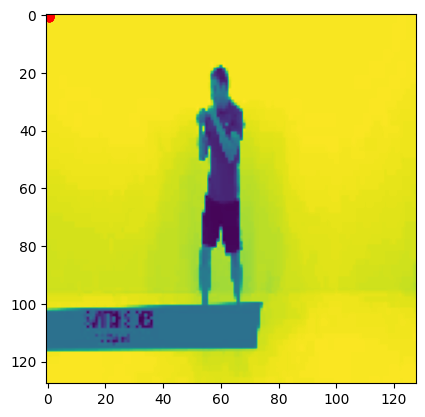

Batch shape (frames): (5, 40, 128, 128, 1)
Batch shape (keypoints): (5, 40, 13, 3)
Batch shape (labels): (5,)


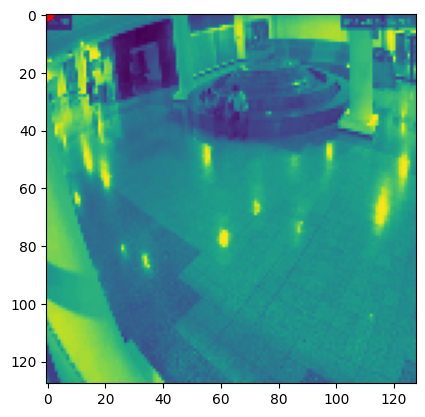

Batch shape (frames): (5, 40, 128, 128, 1)
Batch shape (keypoints): (5, 40, 13, 3)
Batch shape (labels): (5,)


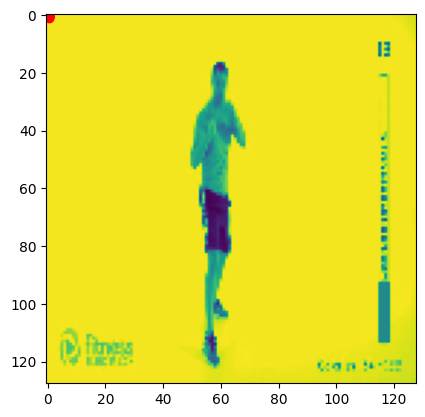

In [ ]:
import h5py
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

class HDF5DataGenerator(Sequence):
    """
    Custom data generator for HDF5 data with video fragments and labels per video.
    """

    def __init__(self, hdf5_file, batch_size, target_size, max_frames, augmentation=None):
        self.hdf5_file = hdf5_file
        self.batch_size = batch_size
        self.target_size = target_size
        self.max_frames = max_frames
        self.augmentation = augmentation
        self.indices = self._get_indices()
        self.on_epoch_end()

    def _get_indices(self):
        # Load data information from the HDF5 file
        with h5py.File(self.hdf5_file, "r") as f:
            return list(f.keys())

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        # Generate a single batch of data and labels
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Load data and labels for the current batch of videos
        X, X_keypoints, y = self.__data_generation(batch_indices)

        return (X, X_keypoints), y

    def on_epoch_end(self):
        # Shuffle indices for each epoch
        np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
      # Initialize arrays for frames, keypoints, and labels
      X = np.zeros((self.batch_size, self.max_frames, *self.target_size, IMG_CHANNELS), dtype=np.float32)
      X_keypoints = np.zeros((self.batch_size, self.max_frames, BODY_KEYPOINTS, 3), dtype=np.float32)
      y = np.zeros((self.batch_size,), dtype=np.float32)

      with h5py.File(self.hdf5_file, 'r') as f:
        for i, idx in enumerate(batch_indices):
          frames = f[f'{idx}/frames'][:]
          keypoints = f[f'{idx}/keypoints'][:]
          label = f[f'{idx}/label'][()]


          if APPLY_GRAYSCALE:
            frames = np.expand_dims(frames, axis=-1)  # Add channel dimension


          # Check for NaNs in the original frames and keypoints
          if np.isnan(frames).any() or np.isnan(keypoints).any():
            print(f"Warning: Found NaN in frames or keypoints for index {idx}. Replacing with default values.")
            frames = np.zeros_like(frames)
            keypoints = np.zeros_like(keypoints)

          # Pad or truncate frames to max_frames
          if frames.shape[0] < self.max_frames:
            pad_width = self.max_frames - frames.shape[0]
            # Pad with copies of the last frame
            last_frame = frames[-1]
            last_keypoints = keypoints[-1]

            frames = np.concatenate([frames, np.tile(last_frame, (pad_width, 1, 1, 1))], axis=0)
            keypoints = np.concatenate([keypoints, np.tile(last_keypoints, (pad_width, 1, 1))], axis=0)
          elif frames.shape[0] > self.max_frames:
            frames = frames[:self.max_frames]
            keypoints = keypoints[:self.max_frames]

          if self.augmentation:
              augmented_frames = []
              for frame in frames:
                  augmented_frame = self.augmentation.random_transform(frame)
                  augmented_frames.append(augmented_frame)
              frames = np.array(augmented_frames)

          X[i] = frames
          X_keypoints[i] = keypoints
          y[i] = label

      return X, X_keypoints, y


# Example function to check the generator output
def check_generator_output(generator, batch_index=0):
    (frames_batch, keypoints_batch), labels_batch = generator[batch_index]

    print(f"Batch shape (frames): {frames_batch.shape}")
    print(f"Batch shape (keypoints): {keypoints_batch.shape}")
    print(f"Batch shape (labels): {labels_batch.shape}")

    # Optionally visualize the first frame and keypoints
    first_frame = frames_batch[0][0]
    first_keypoints = keypoints_batch[0][0]

    plt.imshow(first_frame.astype(np.uint8))
    for x, y, _ in first_keypoints:
        plt.scatter(x, y, c='red')
    plt.show()

# Check the generator output if we created in adanvance
if os.path.exists('test.hdf5'):
  test_generator = HDF5DataGenerator('test.hdf5', batch_size=8, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)
  check_generator_output(test_generator, batch_index=0)

# Check the generator output if we created in adanvance
if os.path.exists(DATASET_TRAIN_PATH):
  test_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)
  check_generator_output(test_generator, batch_index=0)


# Check the generator output if we created in adanvance
if os.path.exists(DATASET_VAL_PATH):
  test_generator = HDF5DataGenerator(DATASET_VAL_PATH, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)
  check_generator_output(test_generator, batch_index=0)


## Load the data

In [ ]:
def load_dataset_data(dataset_name):
    X = []
    y = []
    frame_lengths = []
    with h5py.File(dataset_name, "r") as hdf5_file:
        video_names = list(hdf5_file.keys())
        for video_name in video_names:
            # Access frames and labels datasets for the specific video
            frames = hdf5_file[f"{video_name}/frames"][:]
            labels = hdf5_file[f"{video_name}/labels"][:]

            # Append data and label to batch lists
            X.append(frames)
            y.append(labels)
            frame_lengths.append(frames.shape[0])

    return np.array(X), np.array(y), np.array(frame_lengths)

In [ ]:
def get_dataset_size(dataset_name):
  size = 0
  with h5py.File(dataset_name, 'r') as f:
    video_names = list(f.keys())
    for v in video_names:
      size += len(f[f'{v}/frames'])

  return size

get_dataset_size(DATASET_TRAIN_PATH)

778820

In [ ]:
if INSTALL_STUFF:
    !pip install tensorboard

# launch this command in your terminal if you want to see the tensorboard
# !tensorboard --logdir=C:\Users\margo\OneDrive\UOC\projects\thesis\logs

# Open http://localhost:6006 in your browser to access tensorboard

## Training

### Training using generators

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger

import os

def train_model_using_generators(model, epochs=EPOCHS):
    """Trains a model on the provided data using data generators.

    Args:
      model: The Keras model to be trained.
      epochs: Number of training epochs.

    Returns:
      The trained model, train history, and val generator
    """
    # Generators
    train_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)
    val_generator = HDF5DataGenerator(DATASET_VAL_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)

    # Check class distribution
    check_class_distribution('Train', train_generator)
    check_class_distribution('Val', val_generator)

    # Callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'checkpoints', 'model.{epoch:02d}-{val_loss:.2f}.keras'),
                        save_best_only=True),
        TensorBoard(log_dir=LOGS_PATH),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
        CSVLogger("training_history.csv")
    ]

    # model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy", "precision", "recall"])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "precision", "recall", "mean_squared_error"])
    train_history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=my_callbacks
    )

    return model, train_history, val_generator


## Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, TimeDistributed, Flatten, LSTM, Dropout, Dense, concatenate
from tensorflow.keras.regularizers import l2

def create_video_model(input_shape_frames=(MAX_NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                       input_shape_keypoints=(MAX_NUM_FRAMES, BODY_KEYPOINTS, 3), num_classes=1):

    # Frame input branch
    frames_input = Input(shape=input_shape_frames, name='frames_input')
    x = Conv3D(32, (3,3,3), activation='relu', padding='same')(frames_input)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = Conv3D(64, (3,3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = Conv3D(128, (3,3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = Conv3D(128, (3,3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = LSTM(32, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Keypoints input branch
    keypoints_input = Input(shape=input_shape_keypoints, name='keypoints_input')
    y = TimeDistributed(Flatten())(keypoints_input)
    y = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(y)
    y = Dropout(0.5)(y)
    y = LSTM(32, kernel_regularizer=l2(0.01))(y)
    y = Dropout(0.5)(y)
    y = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(y)
    y = Dropout(0.5)(y)

    # Combine both branches
    combined = concatenate([x, y])
    z = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    z = Dropout(0.5)(z)
    z = Dense(num_classes, activation='sigmoid')(z)

    model = Model(inputs=[frames_input, keypoints_input], outputs=z)
    return model

# Create the model
input_shape_frames = (MAX_NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
input_shape_keypoints = (MAX_NUM_FRAMES, BODY_KEYPOINTS, 3)
video_model = create_video_model(input_shape_frames=input_shape_frames, input_shape_keypoints=input_shape_keypoints, num_classes=1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ frames_input (InputLayer) │ (None, 40, 128, 128,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 40, 128, 128,   │            896 │ frames_input[0][0]     │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 40, 128, 128,   │            128 │ conv3d_4[0][0]         │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 40, 64, 64, 32) │              0 │ batch_normalization_4… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 40, 64, 64, 64) │         55,360 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 40, 64, 64, 64) │            256 │ conv3d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 40, 32, 32, 64) │              0 │ batch_normalization_5… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 40, 32, 32,     │        221,312 │ max_pooling3d_5[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 40, 32, 32,     │            512 │ conv3d_6[0][0]         │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 40, 16, 16,     │              0 │ batch_normalization_6… │
│ (MaxPooling3D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_7 (Conv3D)         │ (None, 40, 16, 16,     │        442,496 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 40, 16, 16,     │            512 │ conv3d_7[0][0]         │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_7           │ (None, 40, 8, 8, 128)  │              0 │ batch_normalization_7… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keypoints_input      

 Total params: 3,445,825 (13.14 MB)

 Trainable params: 3,445,121 (13.14 MB)

 Non-trainable params: 704 (2.75 KB)

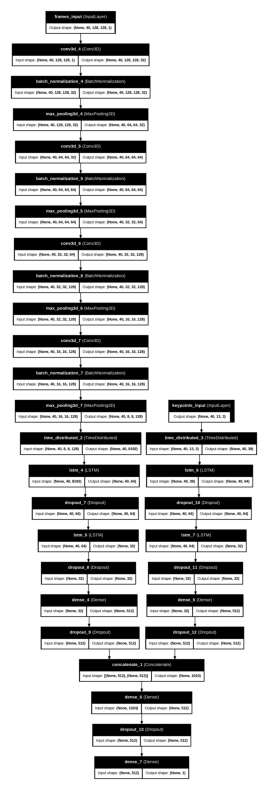

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from scipy import stats as st
import progressbar

m = create_video_model()
m.summary()

def plot_model_diagram(model, file_path='model_diagram.png'):
    plot_model(model, to_file=file_path, show_shapes=True, show_layer_names=True)
    img = plt.imread(file_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_model_diagram(m)

# Evaluation

## Offline Evaluation

In [ ]:
from keras.models import load_model

# Train the model
train_history = None
val_generator = None
if LOAD_MODEL:
  trained_model = load_model(os.path.join(ROOT_PATH, 'model.keras'))
else:
  model = create_video_model()
  trained_model, train_history, val_generator = train_model_using_generators(model, epochs=EPOCHS)
  history = train_history.history
  model.save(os.path.join(MODELS_PATH, 'basic_model.keras'))
  trained_model.save(os.path.join(MODELS_PATH, 'basic_trained_model.keras'))
  trained_model.save(os.path.join(ROOT_PATH, 'model.keras'))


<ipython-input-38-7f56da0f8675>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = label


Train dataset class distribution:
 - Label 0.0: 10639 samples
 - Label 1.0: 8851 samples
Val dataset class distribution:
 - Label 0.0: 2657 samples
 - Label 1.0: 2013 samples
Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3898/3898 ━━━━━━━━━━━━━━━━━━━━ 1107s 280ms/step - accuracy: 0.8441 - loss: 2.0412 - mean_squared_error: 0.1009 - precision: 0.8542 - recall: 0.7904 - val_accuracy: 0.8484 - val_loss: 1.6244 - val_mean_squared_error: 0.0889 - val_precision: 0.7536 - val_recall: 0.9632 - learning_rate: 0.0010
Epoch 2/70
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 1091s 280ms/step - accuracy: 0.8529 - loss: 1.4894 - mean_squared_error: 0.0907 - precision: 0.8527 - recall: 0.8183 - val_accuracy: 0.8636 - val_loss: 1.2703 - val_mean_squared_error: 0.0822 - val_precision: 0.8012 - val_recall: 0.9091 - learning_rate: 0.0010
Epoch 3/70
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 1091s 280ms/step - accuracy: 0.8632 - loss: 1.1070 - mean_squared_error: 0.0813 - precision: 0.8567 - recall: 0.8402 - val_accuracy: 0.8563 - val_loss: 0.9546 - val_mean_squared_error: 0.0819 - val_precision: 0.7973 - val_recall: 0.8943 - learning_rate: 0.0010
Epoch 4/70
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 1091s 280ms/step - accuracy: 0.8665 - loss: 1.1555 - mean_sq

In [ ]:
import pickle
train_history_path = os.path.join(ROOT_PATH, 'train_history.pkl')
if train_history is not None:
  with open(train_history_path, 'wb') as f:
    pickle.dump(train_history, f)

with open(train_history_path, 'rb') as f:
  train_history = pickle.load(f)

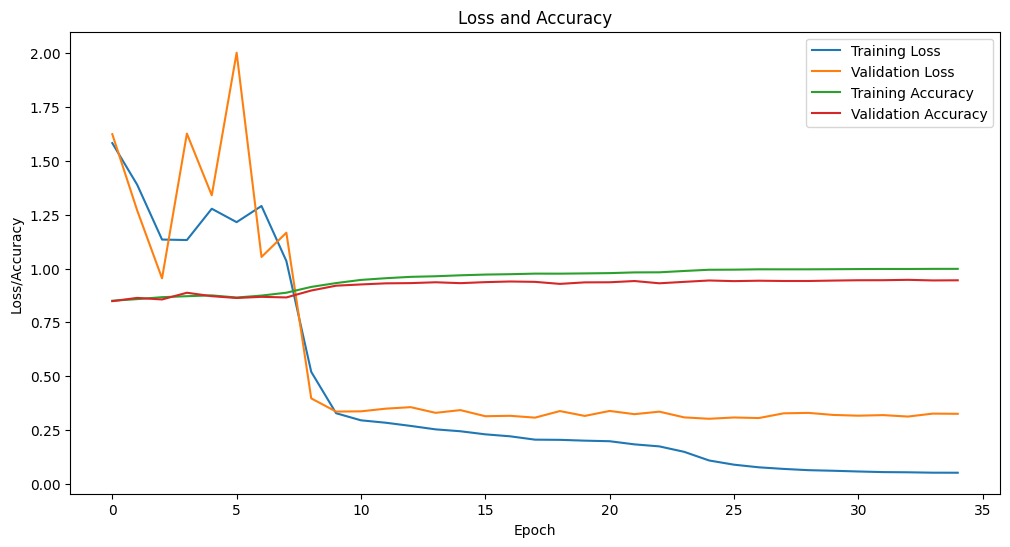

[                                                                        ]   0%<ipython-input-38-7f56da0f8675>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = label
[========================================================================] 100%


Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95      2657
     Violent       0.93      0.94      0.94      2013

    accuracy                           0.94      4670
   macro avg       0.94      0.94      0.94      4670
weighted avg       0.94      0.94      0.94      4670



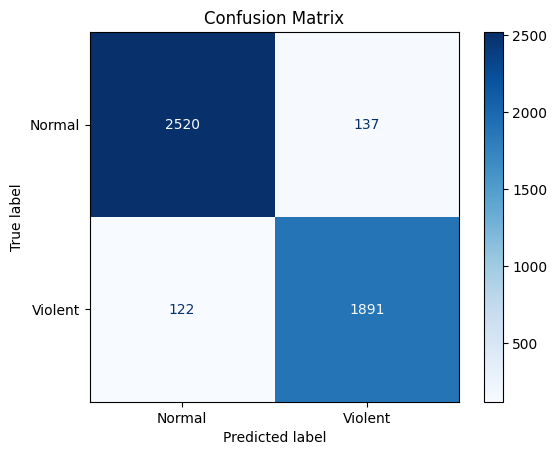

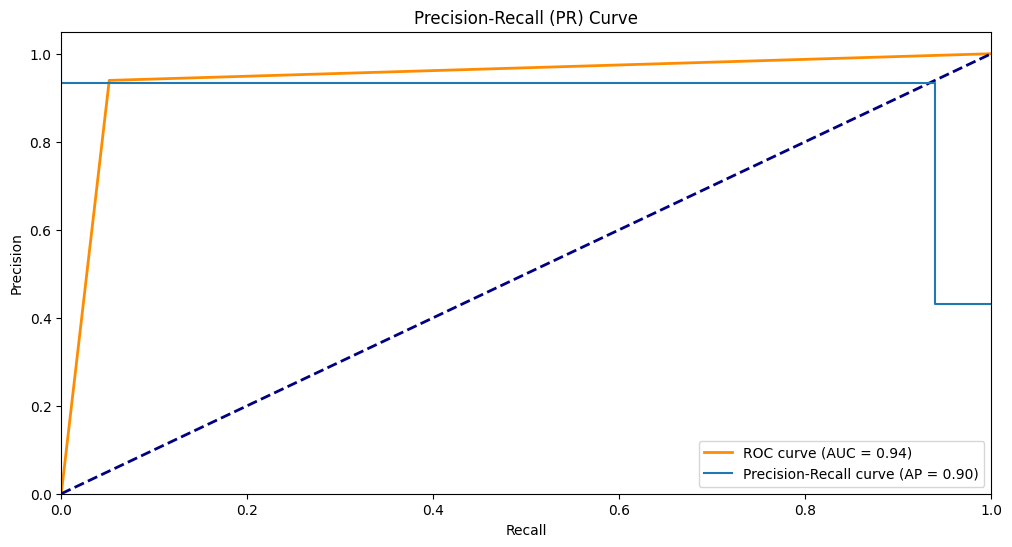

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score


def show_model_metrics(history, model, val_generator):
    # Access training and validation loss/accuracy
    train_loss, val_loss = history["loss"], history["val_loss"]
    train_acc, val_acc = history["accuracy"], history["val_accuracy"]

    # Plot loss and accuracy (combined into one figure)
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

    if val_generator is None:
        return

    # Evaluate model on validation data
    batches_predicted = 0
    bar = progressbar.ProgressBar(maxval=len(val_generator), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    y_true, y_pred = [], []
    for batch_x, batch_y in val_generator:
        if batches_predicted == len(val_generator):
          break
        y_true.extend(batch_y)
        y_pred.extend(np.round(model.predict(batch_x, verbose=0)).astype(int))
        bar.update(batches_predicted)
        batches_predicted += 1
    bar.finish()

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Ensure y_true and y_pred are binary and have the same shape (vectorize)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred = y_pred[:len(y_true)]  # Trim if necessary

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Violent']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violent'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # ROC and PR curves (combined into one figure)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    plt.step(recall, precision, where='post', label='Precision-Recall curve (AP = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc="lower right")
    plt.show()

show_model_metrics(train_history.history, trained_model, val_generator)

## Online Evaluation

In [ ]:
!unzip /content/drive/MyDrive/UOC/TFM_2/validation_tfm.zip

Archive:  /content/drive/MyDrive/UOC/TFM_2/validation_tfm.zip
Written using Zippy
 extracting: TFM/P7050766.mp4        
 extracting: TFM/P7050768.mp4        
 extracting: TFM/P7050771.mp4        
 extracting: TFM/P7050772.mp4        
 extracting: TFM/P7050775.mp4        
 extracting: TFM/P7050778.mp4        
 extracting: TFM/P7050781.mp4        


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf

# Load the model
model = trained_model

# Initialize MediaPipe pose detection
pose = mp.solutions.pose.Pose()
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(
    model_complexity=0,
    min_detection_confidence=0.6
)

def validate_violence(video_path):
  # Open a video capture device
  cap = cv2.VideoCapture(video_path)

  # Initialize frame buffer
  frame_buffer = []
  keypoints_buffer = []
  buffer_size = 40

  while True:
      ret, frame = cap.read()

      if not ret:
          break

      # Preprocess the frame and extract keypoints
      preprocessed_frame, keypoints = preprocess_video_data(frame=frame, mp_pose=mp_pose, pose=pose)

      # Append to buffers
      frame_buffer.append(preprocessed_frame)
      keypoints_buffer.append(keypoints)

      # Perform inference when buffer is full
      if len(frame_buffer) == buffer_size:
          # Stack frames and keypoints into sequences
          input_sequence = np.stack(frame_buffer, axis=0)
          input_keypoints = np.stack(keypoints_buffer, axis=0)

          # Add batch dimension
          input_sequence = np.expand_dims(input_sequence, axis=0)
          input_keypoints = np.expand_dims(input_keypoints, axis=0)

          # Make a prediction
          prediction = model.predict([input_sequence, input_keypoints])
          print(prediction)
          predicted_class = np.argmax(prediction, axis=-1)

          # Get the predicted probability for the violence behaviour
          predicted_probability = prediction[0][predicted_class]
          predicted_probability_value = predicted_probability.item()

          # Clear buffers
          frame_buffer = []
          keypoints_buffer = []

          # Display the predicted class and probability with the appropriate color
          if predicted_probability_value <= 0.5:
              color = (0, 255, 0)  # Green
          else:
              color = (0, 0, 255)  # Red

          # Create a black rectangle for the text background
          text_width, text_height = cv2.getTextSize(f"Predicted violence probability: {predicted_probability_value:.4f}", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
          text_x, text_y = 10, 30
          text_rect = (text_x, text_y - 25, text_width + 10, text_height + 10)
          cv2.rectangle(frame, text_rect, (0, 0, 0), -1)

          # Draw the text on the black rectangle
          cv2.putText(frame, f"Predicted violence probability: {predicted_probability_value:.4f}", (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

          cv2_imshow(frame)


      if cv2.waitKey(1) & 0xFF == ord('q'):
          break

  cap.release()
  cv2.destroyAllWindows()

In [ ]:
validate_violence('/content/TFM/P7050766.mp4')

In [ ]:
validate_violence('/content/TFM/P7050768.mp4')

In [ ]:
validate_violence('/content/TFM/P7050771.mp4')

In [ ]:
validate_violence('/content/TFM/P7050772.mp4')

In [ ]:
validate_violence('/content/TFM/P7050772.mp4')

In [ ]:
validate_violence('/content/TFM/P7050775.mp4')

In [ ]:
validate_violence('/content/TFM/P7050778.mp4')

In [ ]:
validate_violence('/content/TFM/P7050781.mp4')

In [ ]:
if CLEAN_SPACE:
  !rm -rf /content/Info/*
  !rm test.hdf5
  !rm training_history.csv
  !rm -rf /content/models/*
  !rm -rf /content/logs/*